# PyLorentz TIE Reconstruction Demo

Outline 
1. TIE reconstruction of an artificial spin ice 
2. SITIE reconstruction of Bloch-type bubbles in CGT

In this notebook we demonstrate solving the transport of intensity equation (TIE) and finding magnetic induction from an experimental LTEM images. For more information please check out our [wiki/documentation pages](https://pylorentztem.readthedocs.io/en/latest/). 

If you have never used a Jupyter Notebook before we recommend familiarizing yourself with the [notebook basics](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Notebook%20Basics.html). While Python knowledge is not strictly required for running PyLorentz code, a certain familiarity is helpful for understanding how to modify the examples to suit your needs. 

This notebook is ready to be run as-is. The first time, however, you will need to [download the example data from zenodo/DOI](https://zenodo.com). Cells can be executed by selecting and pressing ``shift + enter``, and you can proceed with running all of the cells in order. The python docstrings for these functions can be found on the wiki, but are also viewable in Jupyter. E.g. for the TIE() function, executing a cell containing: `?TIE` will pull up the documentation for that function. 
  
Authors: Arthur McCray, CD Phatak  
V2.0, LBL/ANL, July 2024

Workflow - each step also replaces imstack so is up to date 
1. load - orig_stack
2. preprocess - orig_stack_preprocessed 
3. visualize
4. select ROI - stack_cropped
5. filter - stack_filtered 
6. reconstruct - stack 

can do ROI and filtering in opposite order, check this 

## Importing the necessary modules

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
# matplotlib widget is recommended for interactive ROI selection

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from PyLorentz.io import read_image, write_tif, write_json
from PyLorentz.dataset import ThroughFocalSeries, DefocusedDataset
from PyLorentz.tie import TIE, SITIE
from PyLorentz.visualize import show_im, show_stack, show_2D

## Loading the data
The example data used for all demo notebooks can be [downloaded here](https://zenodo.com). The demo notebook default filepaths expect the downloaded files to be unzipped and placed in PyLorentz/Examples/data. 

Pylorentz is built around two data classes: 
* DefocusedDataset: which contains individual or multiple LTEM images and their associated metadata, to be used for single-image reconstruction methods. 
* ThroughFocalSeries: which contains a TFS of images for use with reconstruction methods that require multiple images. 

In this example we use the TFS class, which consists of an (unflip) aligned stack of images, an aligned stack of flipped images, and an associated metadata.json file. 

Metadata can be read through a json file or entered manually using the TFS.load() method, or a TFS can be created directly from a numpy array using the TFS \_\_init__ directly. The required arguments are: 
- imstack/aligned_file: The aligned (unflip) image stack, or the filepath which will be loaded. 
- flipstack/aligned_flip_file: (optional) Used if performing a reconstruction with two TFS. 
- scale: image scale in nm/pixel 
- defocus_values: list of defocus values in the TFS, formatted as [underfocus2, underfocus1, 0, overfocus1, overfocus2]. The defocus values should match between the unflip and flip stacks if applicable.
- beam_energy: accelerating voltage of the microscope 

Scale, defocus values, and beam_energy are contained within the tfs_mdata.json file. 

# TIE

In [3]:
aligned_file = "./data/cphatak_PyLorentz_example_v2/aligned_stack.tif"
aligned_flip_file = "./data/cphatak_PyLorentz_example_v2/aligned_flip_stack.tif"
tfs_mdata_file = "./data/cphatak_PyLorentz_example_v2/tfs_mdatap.json"
tfs = ThroughFocalSeries.from_files(
    aligned_file=aligned_file,
    aligned_flip_file=aligned_flip_file,
    metadata_file=tfs_mdata_file,
)

tfs.preprocess(fast=True)  # filtering hot/dead pixels and masking

Filtering hot/dead pixels


100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


### Loading data in legacy format with a .fls file
Old data referenced with a .fls file can also be loaded, including using a full_align file containing the concatenated unflip and flip stacks.

We additionally specify the beam_energy here, but this could also be done when performing the TIE reconstruction. 

In [4]:
aligned_file = "./data/cphatak_pytie_example_v1.1/d1_full_align.tif"
data_loc = "./data/cphatak_pytie_example_v1.1/"
fls_filename = "dataset1.fls"

tfs_mdata_file = "./data/cphatak_PyLorentz_example_v2/tfs_mdata.json"
tfs = ThroughFocalSeries.from_files(
    aligned_file=aligned_file,
    legacy_data_loc=data_loc,
    legacy_fls_filename=fls_filename,
    beam_energy=200e3,
)

tfs.preprocess(fast=True)  # filtering hot/dead pixels and masking

Beam energy not found. Set with: DD.energy = <x> [V]
Filtering hot/dead pixels


100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


## Viewing the data


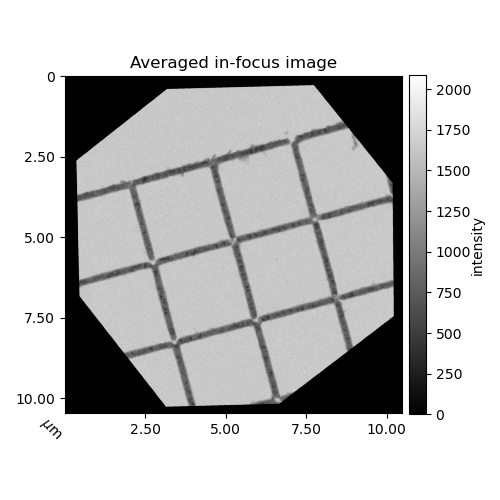

In [5]:
# view the in-focus image using the show_im function
show_im(
    tfs.infocus,
    title="Averaged in-focus image",
    scale=tfs.scale,
    cbar_title="intensity",
    cmap="gray",
)

interactive(children=(IntSlider(value=0, description='i', max=13), Output()), _dom_classes=('widget-interact',…

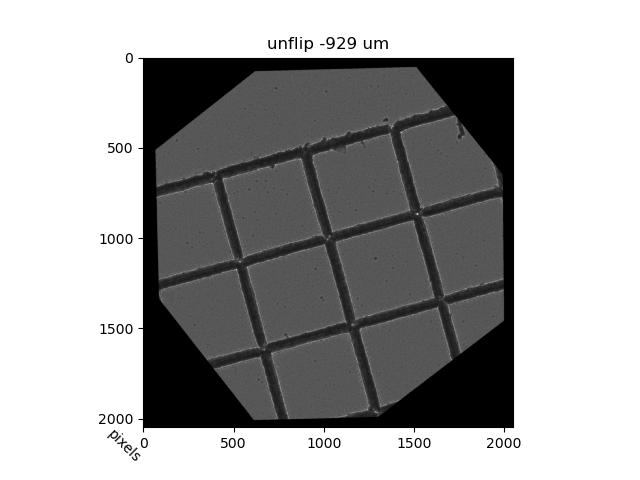

In [6]:
# Scroll through the full stack
full_titles = [f"{fl} {df/1e3:.0f} um" for fl, df in zip(['unflip']*tfs.len_tfs + ['flip']*tfs.len_tfs, tfs.full_defvals)]
show_stack(tfs.full_stack, titles=full_titles)

## Select a region of interest (optional)
There may be times when you would want to only reconstruct part of an image, e.g. because a window edge introduces a high-contrast edge that interferes with the reconstruction or surface contaminates. This can be done interactively in the notebook or manually by setting the ``tfs.transformations`` dictionary. 

<!-- Note that reconstructions of non-square regions can make the results non-quantitative, and that reconstructing regions with large aspect ratios $\scriptsize{\gtrsim}$ 3 will be qualitatively incorrect as well.  -->

Interactive ROI selection:
	Right click | move closest corner to mouse position
	'j'/'k'     | rotate the image, shift + 'j'/'k' to increase step size
	'n'/'m'     | grow/shrink the ROI, shift + 'n'/'m' to increase step size
	arrow keys  | move the ROI, + shift to increase step size
	'c'         | center the ROI on the middle of the image
	's'         | make the ROI square
	shift+'r'   | reset the ROI to the starting conditions
	shift+'f'   | restore the full image with zero rotation
	'esc'       | save transforms and exit
If display is not responding, try clicking on the image and ensuring you ran %matplotlib widget
Starting parameters: 


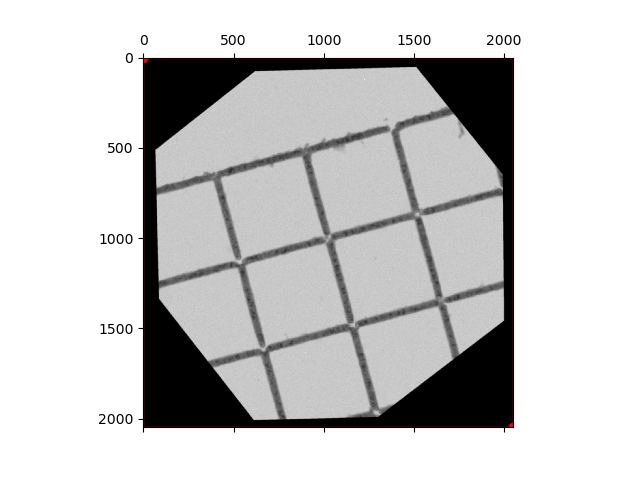

Current parameters:


Rotation:    0 | Points: ( 446,  187), (1449, 1362) | Dimensions (h x w): 1003 x 1175
Setting transforms.
Final image dimensions (h x w): 1003 x 1175
Cropping can be returned to the full image by running self.reset_transforms()


In [7]:
# interactive selection requires matplotlib widget
tfs.select_ROI()
# will default to infocus image, but can input a specific image,
# e.g. dd.select_ROI(dd._orig_imstack[0]), must be of original input size

# In some cases, the interactive plot doesn't load at first. If this happens, try
# pressing j/k to rotate the image, as this will often force it to re-display.
# Or try re-running the cell.

Transformations can also set manually with a dictionary. 
Values can be overwritten/set individually:

In [8]:
print("Transforms dict:\n", tfs.transforms)

Transforms dict:
 {'rotation': 0, 'top': 446, 'bottom': 1449, 'left': 187, 'right': 1362}


In [9]:
tfs.transforms = {"rotation": -15}
### for square/centered region, uncomment the following lines:
tfs.transforms = {
    "rotation": -15,
    "top": 404,
    "bottom": 1604,
    "left": 424,
    "right": 1624,
}

Rotation:  -15 | Points: ( 446,  187), (1449, 1362) | Dimensions (h x w): 1003 x 1175
Rotation:  -15 | Points: ( 404,  424), (1604, 1624) | Dimensions (h x w): 1200 x 1200


Once the transforms are set, then apply them with ``apply_transforms()``. This must be done in a new cell due to notebook/matplotlib compatability limitations. 


In [10]:
tfs.apply_transforms()

100%|██████████| 7/7 [00:04<00:00,  1.44it/s]


Once the transformations are applied, viewing the stacks will show only the transformed images. 

interactive(children=(IntSlider(value=0, description='i', max=13), Output()), _dom_classes=('widget-interact',…

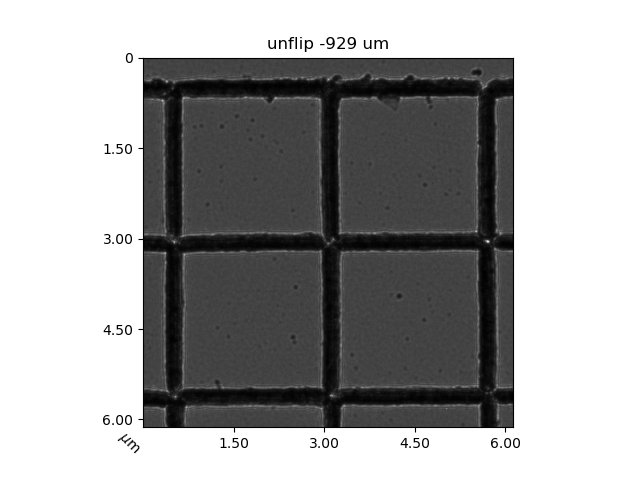

In [11]:
show_stack(tfs.full_stack, scale=tfs.scale, titles=full_titles)

The ROI can also be visualized overlaid on the original image, 

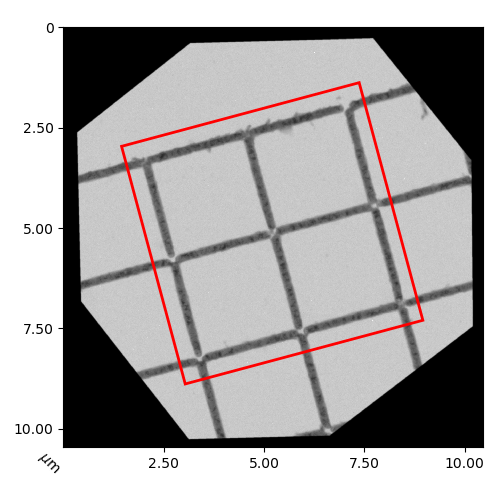

In [12]:
show_im(
    tfs.orig_infocus,
    roi=tfs.transforms,
    roi_color="r", # roi options passed as kwargs: roi_lw, roi_pad
    scale=tfs.scale,
    cbar=False,
)

## TIE phase reconstruction
The TIE reconstruction is performed with the ``TIE`` class, which is initialized with the ``ThroughFocalSeries`` object that we previously created and modified.  

For a TFS with multiple defocus values, the defocus value to reconstruct is specified by passing an index to the ``tie.reconstruct`` method. Index 0 corresponds to the minimum (absolute) defocus value, index 1 to the second smallest, etc. 

When reconstructing data you can also specify optional arguments, namely the Tikhonov frequency and if the image should be symmetrized before reconstructing. Tikhonov filters will be discussed in the next section as it is not necessary for this dataset, but symmetrizing the image can be useful, particularly when reconstructing small regions of a larger magnetic structure (see [Volkov et. al.](https://doi.org/10.1016/S0968-4328(02)00017-3)). For example using a small ROI of this example dataset, the reconstructed magnetic phase shift will be more quantitatively accurate if sym=True.


In [13]:
print(f'Defocus values (um): ± {np.round(tfs.defvals_index, -4)/1e3}')
print('Use defocus_index  =     0 ,  1 ,  2')

Defocus values (um): ± [200. 400. 930.]
Use defocus_index  =     0 ,  1 ,  2


Performing TIE reconstruction with defocus ± 929 um, index = 2
Reconstructing with two TFS flip/unflip to seperate phase_B and phase_E


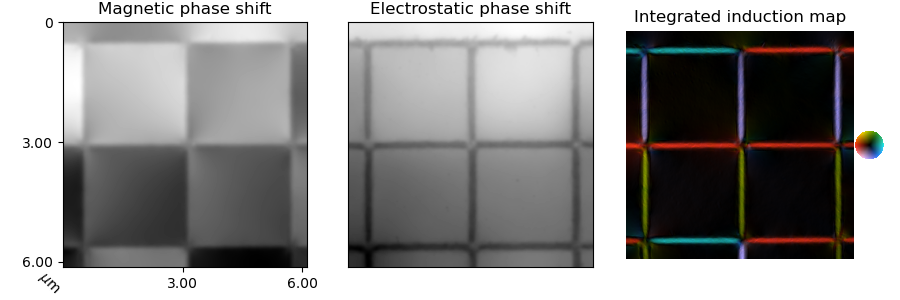

In [16]:
tie = TIE(tfs)

tie.reconstruct(
    index=2,
    sym=True,
    # save = True, ### uncomment to save
)
tie.visualize()

Reconstructed values are put in the ``tie.results`` dictionary. More examples of visualizations can be found in the visualizations_demo.ipynb

dict_keys(['By', 'Bx', 'phase_B', 'phase_E', 'infocus', 'dIdZ_B', 'dIdZ_E'])


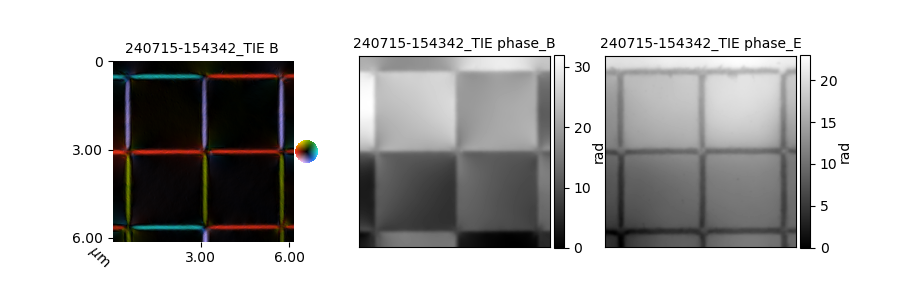

In [23]:
print(tie.results.keys())
fig, axs = plt.subplots(ncols=3, figsize=(9,3))
tie.show_B(show_scale=True, figax=(fig, axs[0]))
tie.show_phase_B(show_scale=False, figax=(fig, axs[1]))
tie.show_phase_E(show_scale=False, figax=(fig, axs[2]))
plt.show()


### save results
The reconstructed images can be saved using the ``tie.save_results`` method. It accepts the following arguments: 

- save_mode [bool or string or list of strings] : 
    - True (default), will save the reconstructed phase(s) and induction components, as well as a colormap image. 
    - "phase" : will save only the phase image(s)
    - "induction" : will save the induction components and a color image
    - list of strings : Passing a list of keys will save the corresponding arrays from the results directory. A key of "color" will save the induction colormap. 
- save_dir [PathLike or None] : The directory in which to save the images. The directory will be created if it does not exist, but parent directories not existing will throw an error. 
    - None (default) will create a directory in ``tfs.data_dir`` / "TIE_outputs". 
- name [string or None] : name with which to prepend the saved files. The files will be saved in for format: "{name}\_{defocus}\_{key}\_.tiff" 
    - None (default) will set the name as: "{date}-{time}\_TIE" 

If any images are saved, a log.json file will also be saved. This contains the recontruction and TFS parameters necessary to reproduce the reconstruction. 

These arguments (save_mode, save_dir, name) can also be passed to ``tie.reconstruct`` or chained, as the methods return ``self``. 

In [20]:
tie.save_results();

Saving tif:  d:\code\PyLorentz\Examples\data\cphatak_pytie_example_v1.1\TIE_outputs\240715-154342_TIE_929um_phase_B.tiff
Saving tif:  d:\code\PyLorentz\Examples\data\cphatak_pytie_example_v1.1\TIE_outputs\240715-154342_TIE_929um_Bx.tiff
Saving tif:  d:\code\PyLorentz\Examples\data\cphatak_pytie_example_v1.1\TIE_outputs\240715-154342_TIE_929um_By.tiff
Saving tif:  d:\code\PyLorentz\Examples\data\cphatak_pytie_example_v1.1\TIE_outputs\240715-154342_TIE_929um_color.tiff
Saving tif:  d:\code\PyLorentz\Examples\data\cphatak_pytie_example_v1.1\TIE_outputs\240715-154342_TIE_929um_phase_E.tiff
Saving json: d:\code\PyLorentz\Examples\data\cphatak_pytie_example_v1.1\TIE_outputs\240715-154342_TIE_929um_log.json


A .png file for any of the images can also be saved using the show_im and show_2D functions respectively.

Saving: d:\code\PyLorentz\Examples\data\cphatak_pytie_example_v1.1\TIE_outputs\240715-154342_TIE_929um_B.png


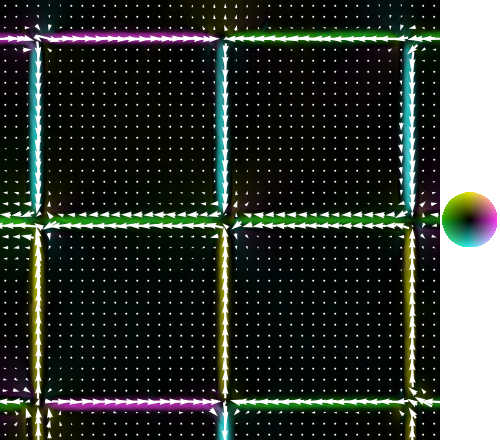

In [24]:
fname = f"{tie._save_name}_{tie._fmt_defocus(tie.recon_defval)}_B.png"
show_2D(tie.Bx,
        tie.By,
        num_arrows=40,
        arrow_size=2,
        arrow_width=6,
        cmap="4fold",
        save=tie.save_dir / fname
        )

# Single Image Reconstruction (SITIE)
Uniformly thin magnetic samples can be reconstructed from a single defocused image if their only source of contrast is magnetic Fresnel contrast. The previous example showed images of an island structure for which that is not the case, and we require two TFS to reconstruct the phase. 

Here we demonstrate the SITIE method for an experimental image of magnetic bubbles in Cr<sub>2</sub>Ge<sub>2</sub>Te<sub>6</sub>: 

In [25]:
file_CGT = Path("./data/CGT_Tx0_Ty0_B500_df-0.7mm_T30K.dm4")
image, mdata = read_image(file_CGT)
mdata["defocus_values"] = -0.7 # from filename, not in file metadata
mdata["defocus_unit"] = "mm"

print("metadata from image:")
mdata

metadata from image:


{'filepath': 'd:\\code\\PyLorentz\\Examples\\data\\CGT_Tx0_Ty0_B500_df-0.7mm_T30K.dm4',
 'filename': 'CGT_Tx0_Ty0_B500_df-0.7mm_T30K.7mm_T30K.dm4',
 'scale': 1.6963549423962831,
 'scale_unit': 'nm',
 'defocus_values': -0.7,
 'defocus_unit': 'mm',
 'beam_energy': 200000.0}

We create the Defocused Dataset with the image and metadata

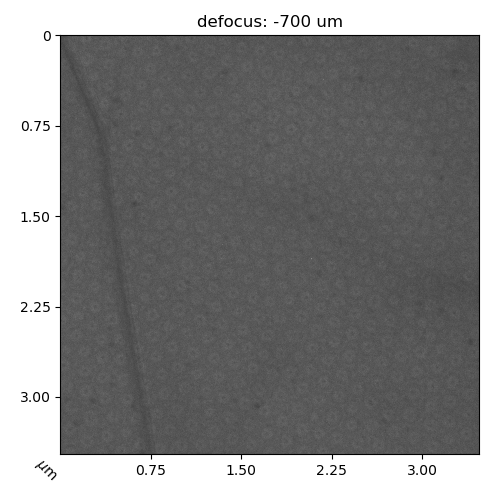

In [26]:
dd = DefocusedDataset.load(
    images=image,
    metadata=mdata,

)

## equivalently, we could do:
# dd = DefocusedDataset.load(
#     images=file_CGT,
#     defvals=-700_000 # specified because not in the metadata, will throw an error otherwise
# )

dd.show_im()

The contrast is bad due to hot pixels, filtering them will help this: 

Filtering hot/dead pixels


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


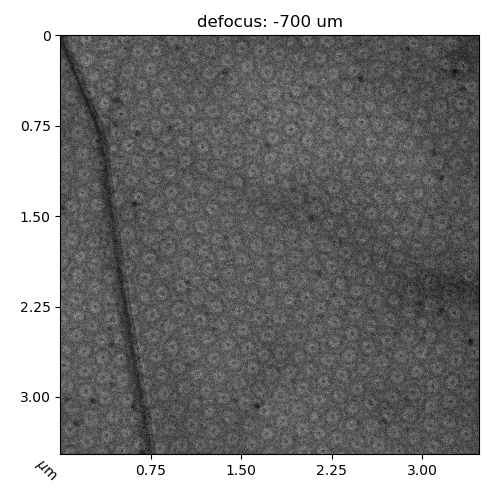

In [27]:
dd.preprocess()
dd.show_im()

select a subregion, could also do ``dd.select_ROI()`` for interactive choosing same as before

Rotation:    0 | Points: (1134,  775), (1590, 1231) | Dimensions (h x w):  456 x  456


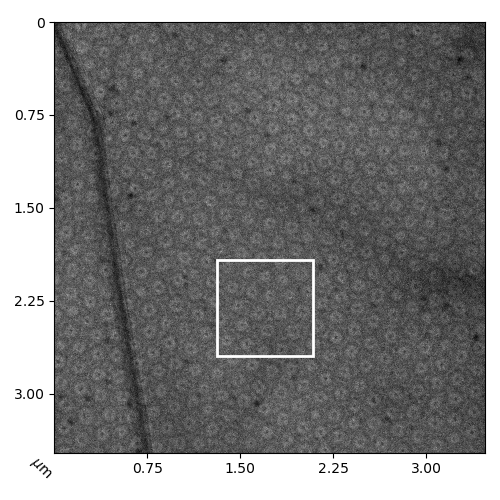

In [28]:
## one region that works pretty well
dd.transforms = {'rotation': 0, 'top': 1134, 'bottom': 1590, 'left': 775, 'right': 1231}
dd.apply_transforms()
show_im(dd._orig_images_preprocessed[0], roi=dd.transforms, scale=dd.scale, cbar=False)

Performing SITIE reconstruction with defocus -700 um, index = 0


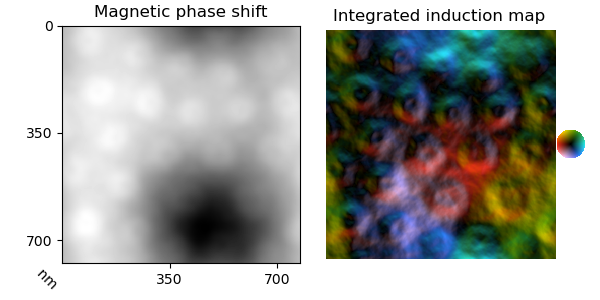

In [29]:
sitie = SITIE(dd=dd)
sitie.reconstruct().visualize();

qc: 1000.0 nm = 1.0 um
Performing SITIE reconstruction with defocus -700 um, index = 0
Using a Tikhonov frequency [1/nm]: 1.0e-03


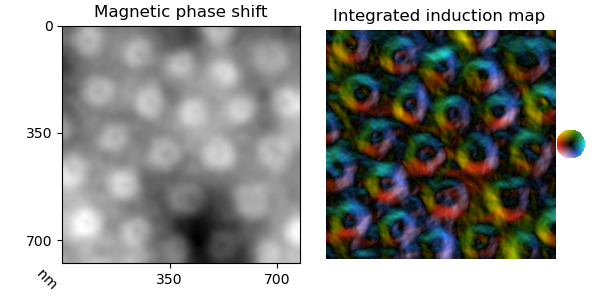

In [30]:
sitie_qc = SITIE(dd=dd)
qc = 0.001
print(f"qc: {1/qc} nm = {1/qc/1000} um")
sitie_qc.reconstruct(
    qc=qc,
    sym=True,
    save=False,
)
sitie_qc.visualize();

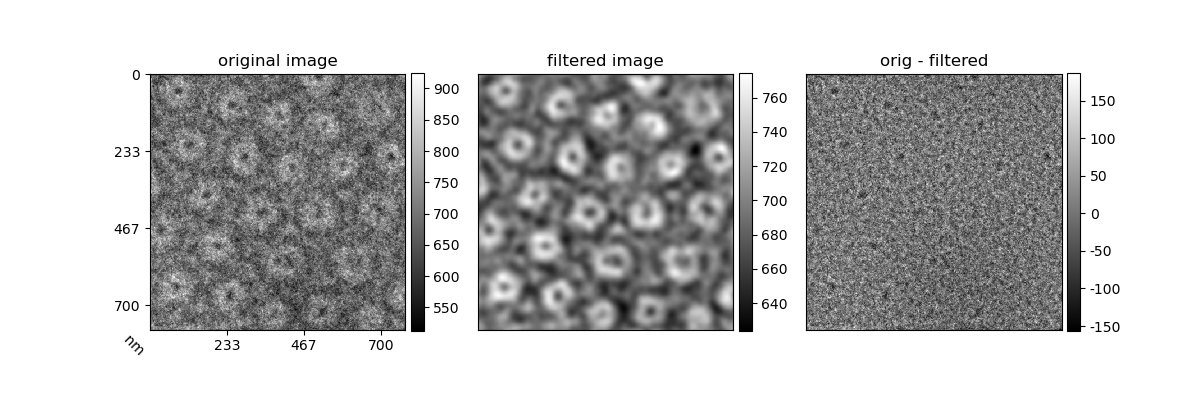

In [31]:
q_lowpass = 1 / 500  # 1/nm
q_highpass = 1 / 50  # 1/nm
dd.filter(
    q_lowpass=q_lowpass, q_highpass=q_highpass, filter_type="butterworth", show=True
)


qc: 1000.0 nm = 1.0 um
Performing SITIE reconstruction with defocus -700 um, index = 0
Using a Tikhonov frequency [1/nm]: 1.0e-03


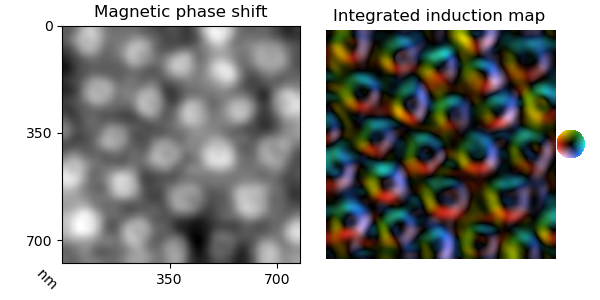

In [32]:
sitie_qc_filt = SITIE(dd=dd)
qc = 0.001
print(f"qc: {1/qc} nm = {1/qc/1000} um")
sitie_qc_filt.reconstruct(
    qc=qc,
    sym=True,
    save=False,
)
sitie_qc_filt.visualize();

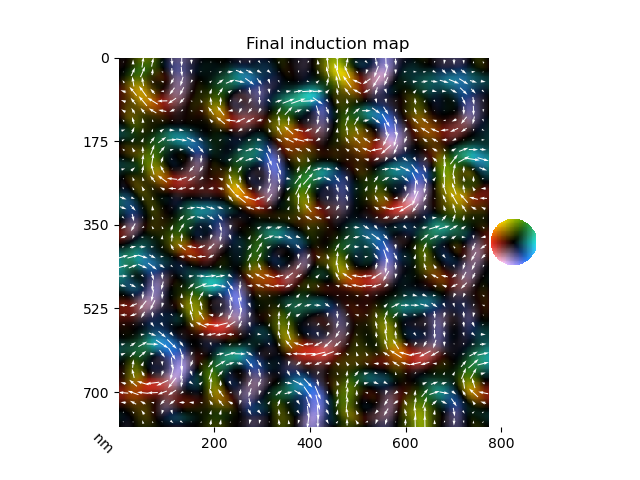

In [33]:
show_2D(
    sitie_qc_filt.Bx,
    sitie_qc_filt.By,
    num_arrows=40,
    title="Final induction map",
    scale=sitie.scale,
)

--- end notebook ---